# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [1]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [2]:
# File path
npz_file_path = os.path.join("./data", "padded_simulated_data.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print(f"Successfully loaded arrays and config from {npz_file_path}.")

Successfully loaded arrays and config from ./data/padded_simulated_data.npz.


In [3]:
# Reduce Stepsize px
step_size_px = 10
points_per_wavelength = 4
empty_space_px = 0

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)

sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
    empty_space_px=empty_space_px
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-14 21:29:31,790 - INFO - === Scan Summary ===
2025-12-14 21:29:31,791 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 21:29:31,792 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-14 21:29:31,794 - INFO -   Sample Pixels:          1501 px
2025-12-14 21:29:31,797 - INFO -   Step size:              10 px
2025-12-14 21:29:31,799 - INFO -   Number of scan points:  60
2025-12-14 21:29:31,800 - INFO -   Steps in z:             472
2025-12-14 21:29:31,801 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 21:29:31,803 - INFO -   Probe Pixels:           100 px
2025-12-14 21:29:31,804 - INFO -   Max Overlap:            9.000e-06 m
2025-12-14 21:29:31,805 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 60 -> 10
Points per wavelength: 32 -> 4


## 3. Reduce Data Dimensionality

In [4]:
# Remove Empty Space Padding from ref_index
print("Cropping empty space from ref_index and exit_waves...")

print(f"original shape:{exit_waves.shape}")
if loaded_sim_config["empty_space_px"] > empty_space_px:
    crop_px = loaded_sim_config["empty_space_px"] - empty_space_px
else:
    crop_px = loaded_sim_config["empty_space_px"]
print(
    f"Remove px: {crop_px} pixels on each side."
)
data_ew_cropped = exit_waves[
    :,
    crop_px:-crop_px,
]
print(f"cropped shape:{data_ew_cropped.shape}")

Cropping empty space from ref_index and exit_waves...
original shape:(60, 15001)
Remove px: 3000 pixels on each side.
cropped shape:(60, 9001)


Original exit waves shape: (60, 9001)
Coarse exit waves shape: (60, 1501)


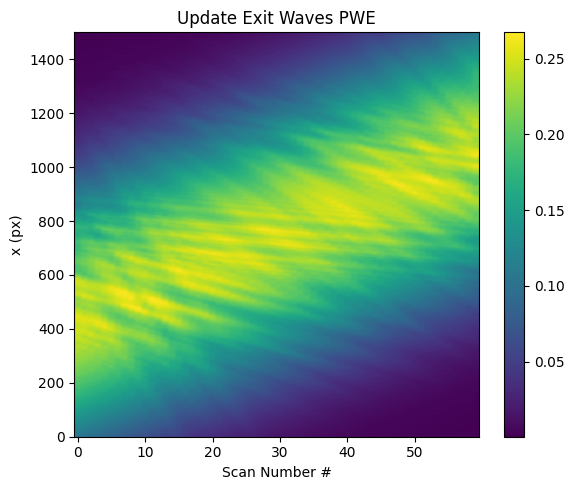

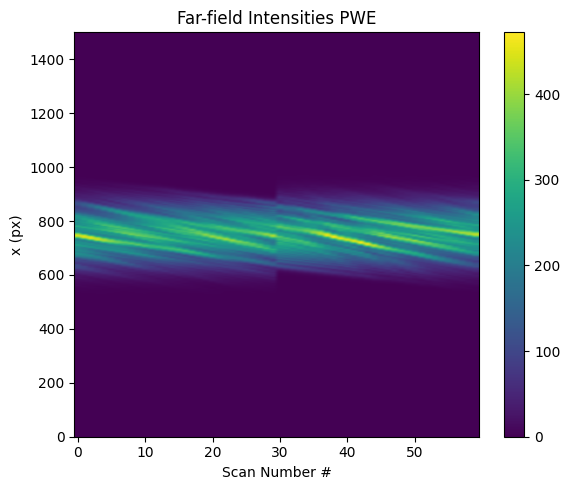

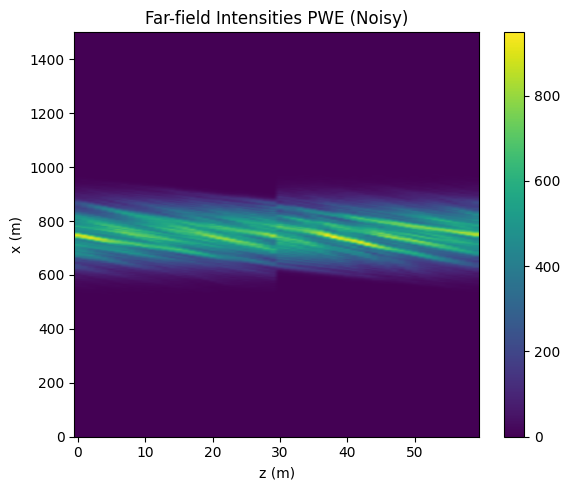

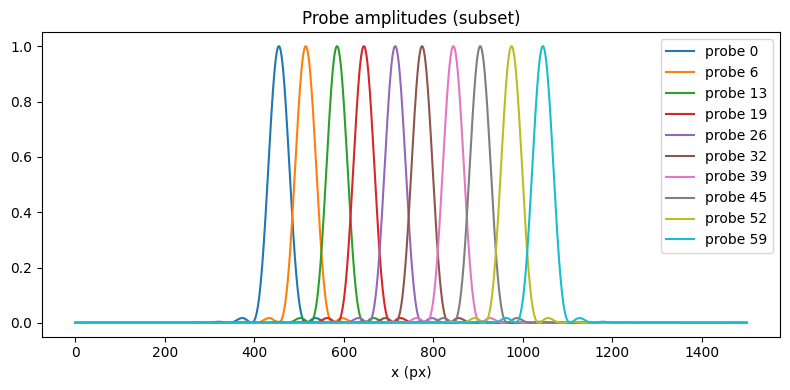

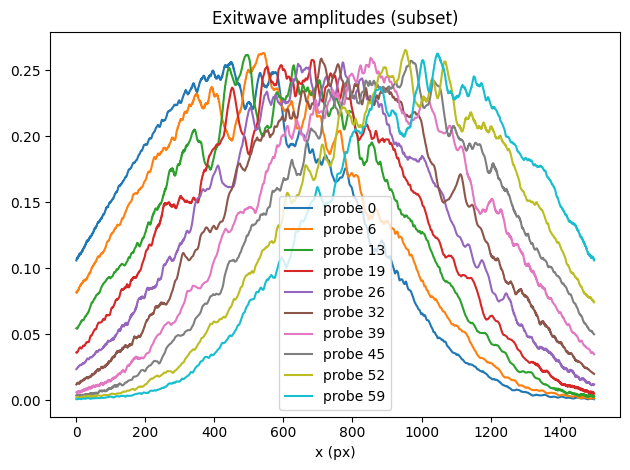

In [ ]:
# Reduce Pixel Size by Zooming Exit Waves
original_shape = data_ew_cropped.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(data_ew_cropped, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {data_ew_cropped.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

# Original Refactive Index Shap
ref_index_shape = ref_index.shape
print(f"Original ref_index shape: {ref_index_shape}")
target_shape = (simulation_space.effective_nx, simulation_space.nz)
zoom_factors = np.array(target_shape) / np.array(ref_index_shape)
ref_index_zoomed = zoom(ref_index, zoom_factors)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-14 21:49:18,290 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 21:49:31,019 - INFO - [Iter 001] Mean Loss = 0.134459, Time = 12.73 seconds
2025-12-14 21:49:39,858 - INFO - [Iter 002] Mean Loss = 0.120587, Time = 8.84 seconds
2025-12-14 21:49:47,874 - INFO - [Iter 003] Mean Loss = 0.118107, Time = 8.01 seconds
2025-12-14 21:49:55,818 - INFO - [Iter 004] Mean Loss = 0.116983, Time = 7.94 seconds
2025-12-14 21:50:06,432 - INFO - [Iter 005] Mean Loss = 0.116259, Time = 10.61 seconds
2025-12-14 21:50:14,627 - INFO - [Iter 006] Mean Loss = 0.115721, Time = 8.19 seconds
2025-12-14 21:50:26,070 - INFO - [Iter 007] Mean Loss = 0.115297, Time = 11.44 seconds
2025-12-14 21:50:38,645 - INFO - [Iter 008] Mean Loss = 0.114956, Time = 12.57 seconds
2025-12-14 21:50:46,692 - INFO - [Iter 009] Mean Loss = 0.114680, Time = 8.04 seconds
2025-12-14 21:50:56,170 - INFO - [Iter 010] Mean Loss = 0.114461, Time = 9.48 seconds
2025-12-14 21:51:05,575 - INFO - [Iter 011] Mean Loss = 0.114288, Time = 9.40 seconds
2025-12-14 21:51:18,837 - INFO - [Iter 012] Mean L

Reconstruction time: 296.26 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

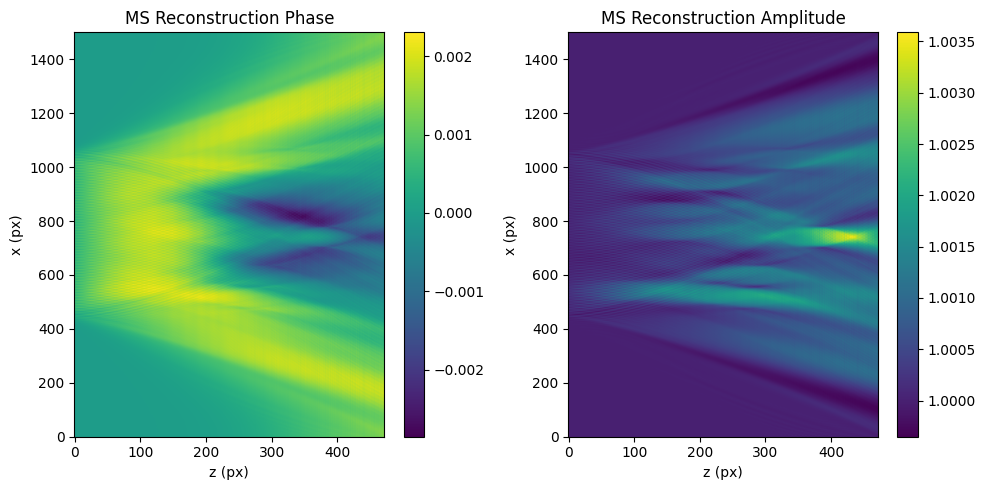

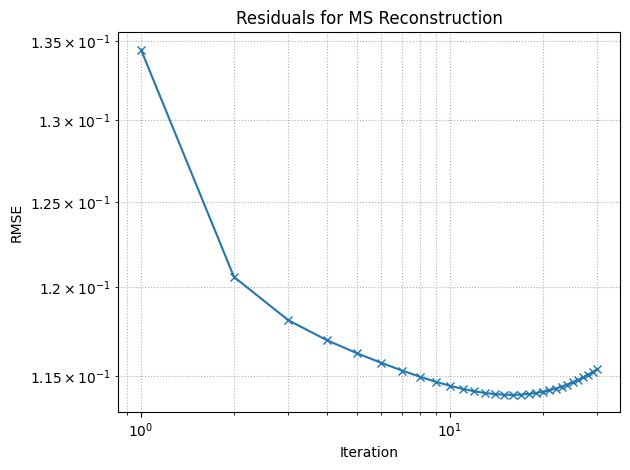

In [13]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

2025-12-14 21:54:15,595 - INFO - Initializing Least Squares Solver...
2025-12-14 21:54:15,649 - INFO - Iteration 1/30
2025-12-14 21:54:19,049 - INFO -     RMSE: 0.10736621814304886
2025-12-14 21:54:27,339 - INFO -     Iteration 1 took 11.69 seconds.
2025-12-14 21:54:27,340 - INFO - Iteration 2/30
2025-12-14 21:54:31,266 - INFO -     RMSE: 0.10335497749869499
2025-12-14 21:54:44,286 - INFO -     Iteration 2 took 16.95 seconds.
2025-12-14 21:54:44,292 - INFO - Iteration 3/30
2025-12-14 21:54:48,564 - INFO -     RMSE: 0.1008188855484073
2025-12-14 21:54:57,697 - INFO -     Iteration 3 took 13.41 seconds.
2025-12-14 21:54:57,702 - INFO - Iteration 4/30
2025-12-14 21:55:01,545 - INFO -     RMSE: 0.09880323514196701
2025-12-14 21:55:10,361 - INFO -     Iteration 4 took 12.66 seconds.
2025-12-14 21:55:10,364 - INFO - Iteration 5/30
2025-12-14 21:55:14,105 - INFO -     RMSE: 0.09728377299894347
2025-12-14 21:55:26,531 - INFO -     Iteration 5 took 16.17 seconds.
2025-12-14 21:55:26,532 - INFO 

Reconstruction time: 432.89 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

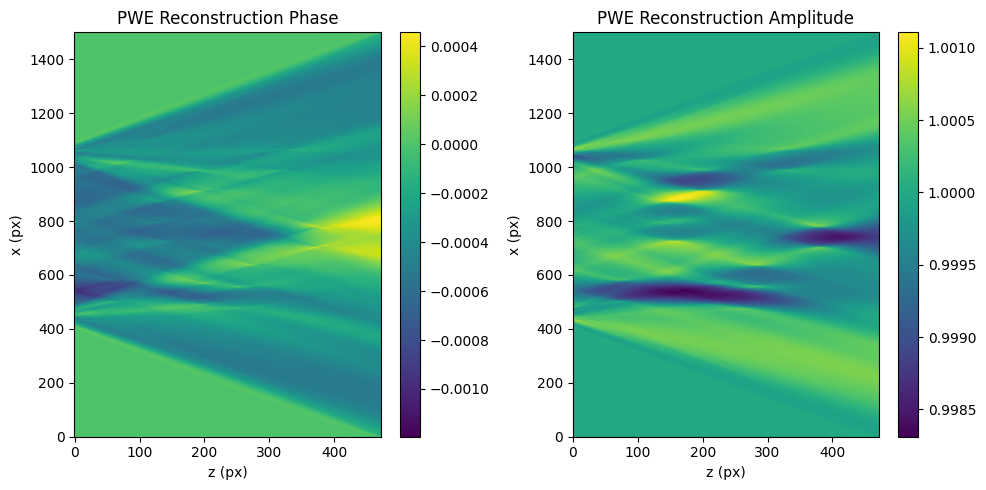

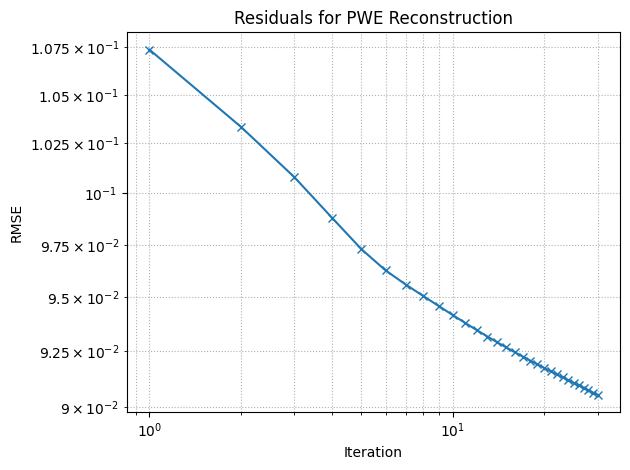

In [14]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

## Phase Retrieval

2025-12-14 21:43:04,904 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-14 21:43:13,146 - INFO - [Iter 001] Mean Loss = 0.016868, Time = 8.24 seconds
2025-12-14 21:43:23,285 - INFO - [Iter 002] Mean Loss = 0.015386, Time = 10.14 seconds
2025-12-14 21:43:35,512 - INFO - [Iter 003] Mean Loss = 0.015029, Time = 12.23 seconds
2025-12-14 21:43:43,825 - INFO - [Iter 004] Mean Loss = 0.014850, Time = 8.31 seconds
2025-12-14 21:43:51,884 - INFO - [Iter 005] Mean Loss = 0.014717, Time = 8.06 seconds
2025-12-14 21:43:59,830 - INFO - [Iter 006] Mean Loss = 0.014603, Time = 7.94 seconds
2025-12-14 21:44:10,864 - INFO - [Iter 007] Mean Loss = 0.014500, Time = 11.03 seconds
2025-12-14 21:44:19,328 - INFO - [Iter 008] Mean Loss = 0.014404, Time = 8.46 seconds
2025-12-14 21:44:26,489 - INFO - [Iter 009] Mean Loss = 0.014316, Time = 7.16 seconds
2025-12-14 21:44:33,057 - INFO - [Iter 010] Mean Loss = 0.014235, Time = 6.57 seconds
2025-12-14 21:44:39,631 - INFO - [Iter 011] Mean Loss = 0.014

Reconstruction time: 245.29 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

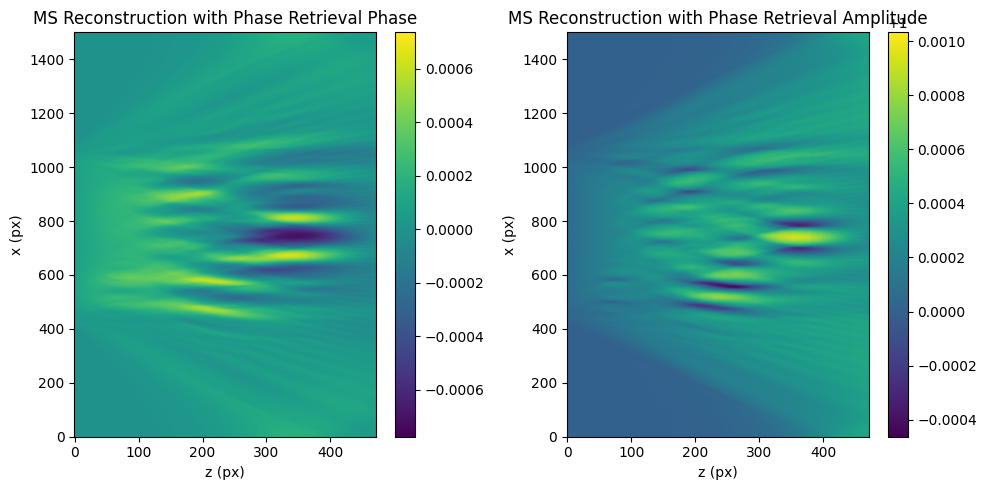

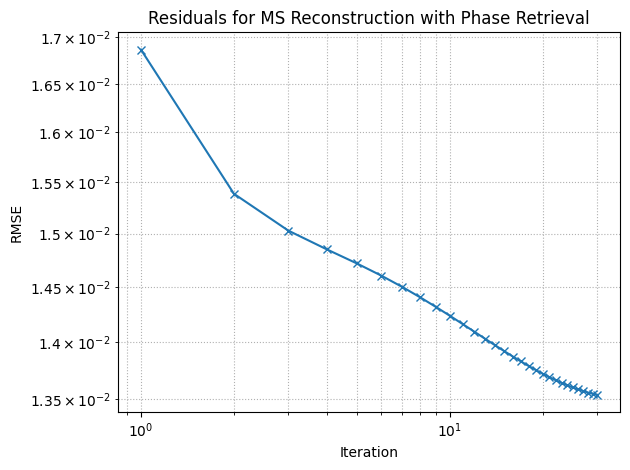

In [12]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval",
)

2025-12-14 21:34:51,366 - INFO - Initializing Least Squares Solver...
2025-12-14 21:34:51,428 - INFO - Iteration 1/30
2025-12-14 21:34:55,125 - INFO -     RMSE: 0.016499148532374816
2025-12-14 21:35:03,406 - INFO -     Iteration 1 took 11.98 seconds.
2025-12-14 21:35:03,407 - INFO - Iteration 2/30
2025-12-14 21:35:07,303 - INFO -     RMSE: 0.015026457686305268
2025-12-14 21:35:16,169 - INFO -     Iteration 2 took 12.76 seconds.
2025-12-14 21:35:16,172 - INFO - Iteration 3/30
2025-12-14 21:35:22,985 - INFO -     RMSE: 0.013831407094557472
2025-12-14 21:35:31,313 - INFO -     Iteration 3 took 15.14 seconds.
2025-12-14 21:35:31,315 - INFO - Iteration 4/30
2025-12-14 21:35:35,671 - INFO -     RMSE: 0.012794710352106917
2025-12-14 21:35:45,779 - INFO -     Iteration 4 took 14.46 seconds.
2025-12-14 21:35:45,781 - INFO - Iteration 5/30
2025-12-14 21:35:49,967 - INFO -     RMSE: 0.011955057669114214
2025-12-14 21:36:01,312 - INFO -     Iteration 5 took 15.53 seconds.
2025-12-14 21:36:01,313 -

Reconstruction time: 412.53 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

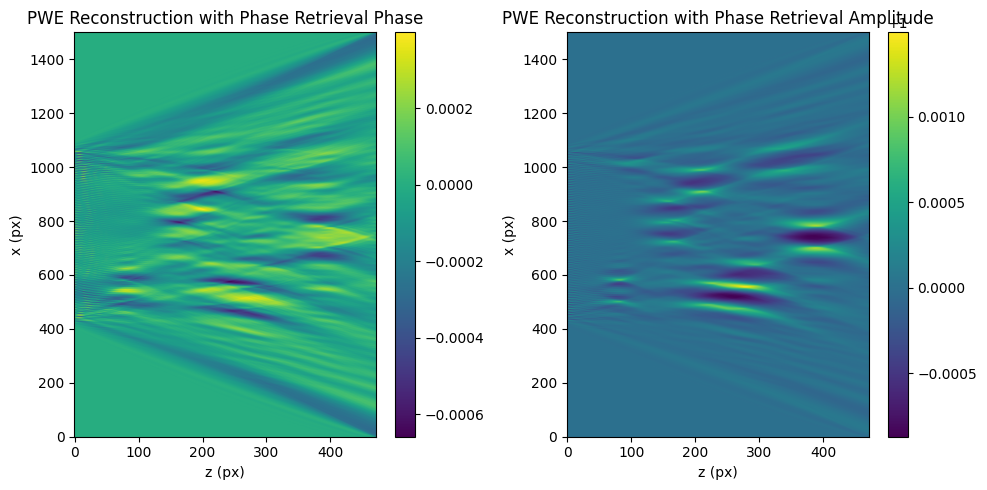

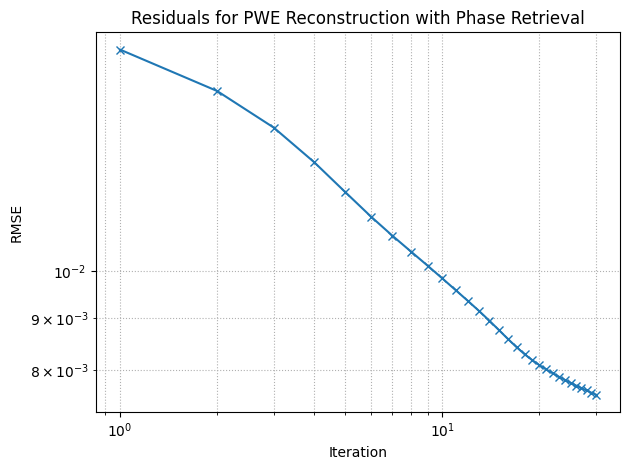

In [9]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval",
)